In [5]:
%%capture


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import plotly.express as px
import spacy
from collections import Counter
import tensorflow as tf
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from itertools import chain

import scipy.stats

from sklearn.metrics import make_scorer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
model = spacy.load("en_core_web_sm")
sns.set_style('darkgrid')

import re

from nltk import bigrams, trigrams


In [6]:
processed_doc = model(u"Arun lives in India")

for token in processed_doc:
  print(token.text, " -- ", token.pos_)

Arun  --  NOUN
lives  --  VERB
in  --  ADP
India  --  PROPN


In [7]:
for ent in processed_doc.ents:
    print(processed_doc)
    print(ent.text, " -- ", ent.start_char, " -- ", ent.end_char, " -- ", ent.label_)

Arun lives in India
India  --  14  --  19  --  GPE


In [8]:
email= (' I am Raman Williams, the Team Lead for APAC and ANZ.'
        ' The past month has been extremely hectic and we havent'
        'had a chance to properly meet all the new people who have joined our team recently.'
        ' Mr. Dinesh, Mr. Ramesh, and I were discussing how it might be a good idea to catch up once a'
        'month over a weekend brunch. What are your thoughts?')
processed_email = model(email)

In [9]:
anonymized_email = list(email)

for ent in processed_email.ents:
  if(ent.label_ == 'PERSON'):
    for char_pos in range(ent.start_char, ent.end_char):
      anonymized_email[char_pos] = '*'


print("\n\n-- After Anonymization--\n")
"".join(anonymized_email)




-- After Anonymization--



' I am **************, the Team Lead for APAC and ANZ. The past month has been extremely hectic and we haventhad a chance to properly meet all the new people who have joined our team recently. Mr. ******, Mr. ******, and I were discussing how it might be a good idea to catch up once amonth over a weekend brunch. What are your thoughts?'

In [14]:
data_ner = pd.read_csv("ner-1.csv", encoding = "unicode_escape", error_bad_lines=False,  \
                       usecols=['sentence_idx', 'word', 'tag']
)
print(data_ner.shape)
data_ner.head()

(661593, 3)


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


In [15]:
print(data_ner[data_ner['sentence_idx'] == 'prev-lemma'])

       sentence_idx           word              tag
281835   prev-lemma  prev-prev-iob  prev-prev-lemma


In [16]:
data_ner  = data_ner[data_ner['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)
data_ner['sentence_idx'] = data_ner['sentence_idx'].apply(int)
data_ner['tag'] = data_ner['tag'].apply(lambda x: x if x == 'O' else x[2:])
print(data_ner.shape)
data_ner.head()

(661591, 3)


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


In [17]:
# in the below example, India is found as Geo polictical entities. this is how each sentance and tags are marked in the data as input sentances
# and output labels.

def extract_entities(doc):
    entities = []
    if doc.ents:
        for ent in doc.ents:
            entity = {
                "text": ent.text,
                "start_char": ent.start_char,
                "end_char": ent.end_char,
                "label": ent.label_,
                "label_description": spacy.explain(ent.label_)
            }
            entities.append(entity)
    else:
        print("No named entities found.")
    return entities

doc = model(u'India is a great country.')
extract_entities (doc)

[{'text': 'India',
  'start_char': 0,
  'end_char': 5,
  'label': 'GPE',
  'label_description': 'Countries, cities, states'}]

In [18]:
print("Number of sentances      = {0}".format(data_ner['sentence_idx'].nunique()))
print("Number of unique words:  = {0}".format(len(list(set(data_ner["word"].values)))))
print("Number of unique tags :  = {0}".format(len(list(set(data_ner["tag"].values)))))
print("unique tags           :  = {0}".format((list(set(data_ner["tag"].values)))))

Number of sentances      = 17371
Number of unique words:  = 21499
Number of unique tags :  = 9
unique tags           :  = ['gpe', 'O', 'geo', 'per', 'art', 'nat', 'eve', 'org', 'tim']


In [19]:
fig = px.histogram(data_ner, x=data_ner['sentence_idx'].value_counts().values ,nbins=50)
fig.update_layout(
    title="Sentences",
    xaxis_title="Sentences with number of words",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

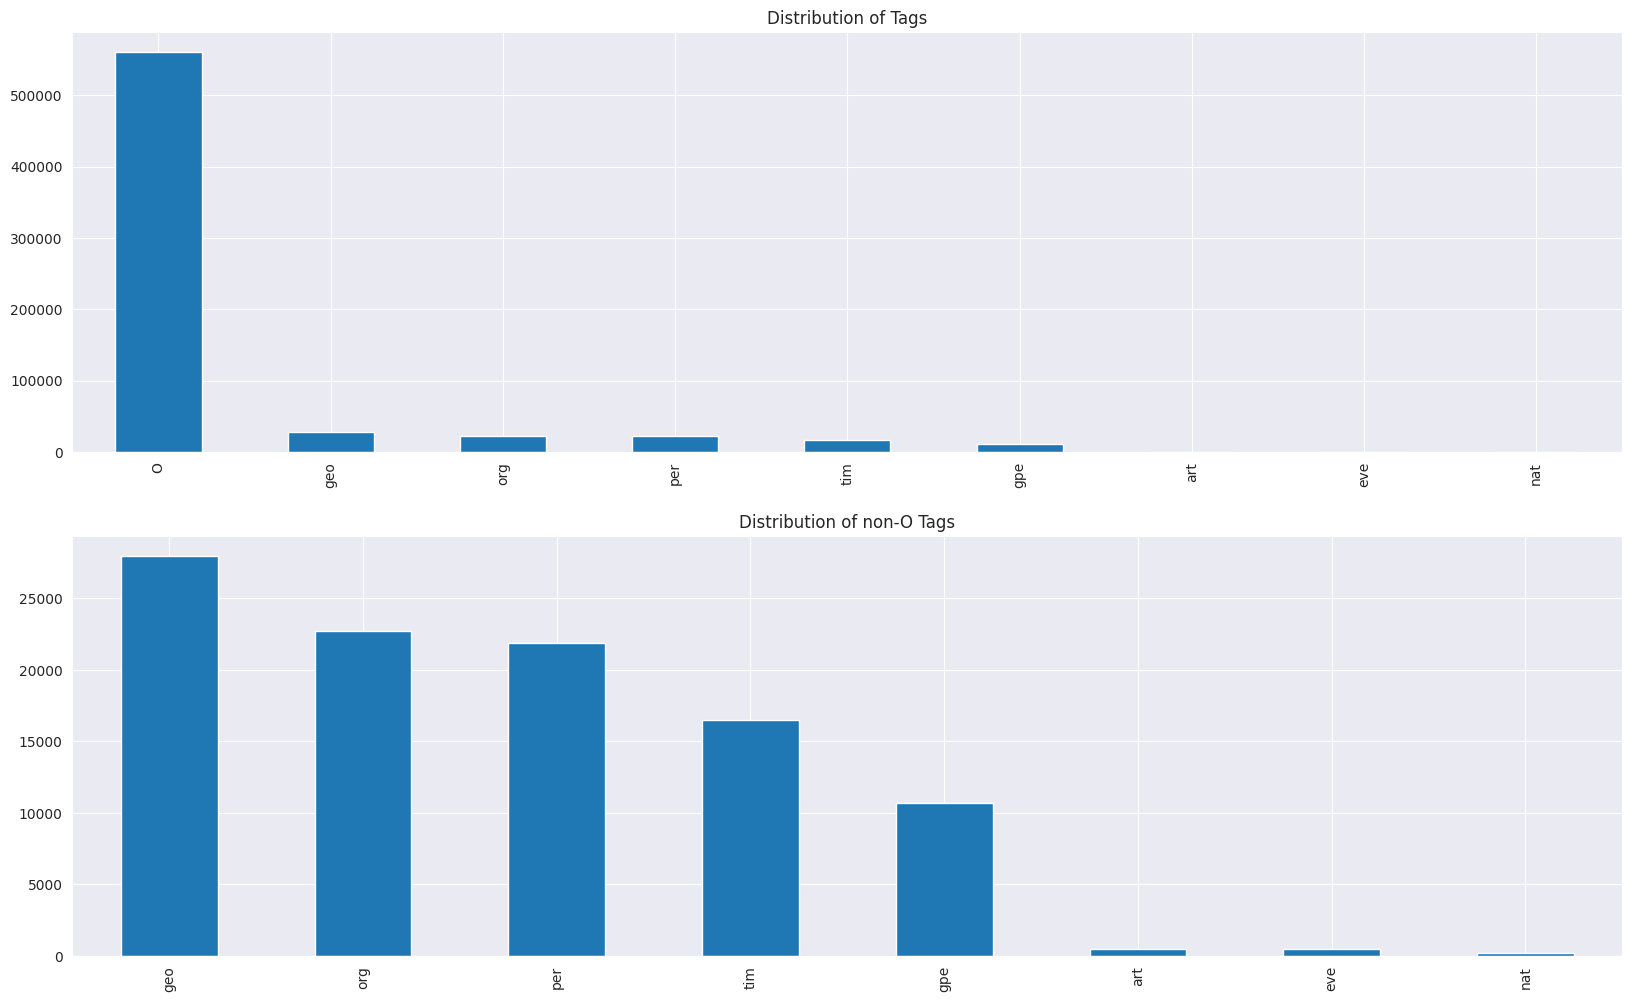

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data_ner.tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data_ner[data_ner.tag != 'O'].tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')
fig.show()

In [21]:
words = pd.DataFrame(data_ner.groupby('sentence_idx')['word'].apply(list))
tags = data_ner.groupby('sentence_idx')['tag'].apply(list)
words['tag'] = tags
words['sentence'] = words['word'].apply(lambda x: ' '.join(x))
words['tag_combine'] = words['tag'].apply(lambda x: ' '.join(x))
words = words.reset_index()
words.head()

,sentence_idx,word,tag,sentence,tag_combine
0,1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, geo, O, O, O, O, O, geo, O,...",Thousands of demonstrators have marched throug...,O O O O O O geo O O O O O geo O O O O O gpe O ...
1,2,"[Families, of, soldiers, killed, in, the, conf...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O O per O O O ...
2,3,"[They, marched, from, the, Houses, of, Parliam...","[O, O, O, O, O, O, O, O, O, O, O, geo, geo, O,...",They marched from the Houses of Parliament to ...,O O O O O O O O O O O geo geo O O O O O O O O ...
3,4,"[Police, put, the, number, of, marchers, at, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","Police put the number of marchers at 10,000 wh...",O O O O O O O O O O O O O O O O O O O O O O O ...
4,5,"[The, protest, comes, on, the, eve, of, the, a...","[O, O, O, O, O, O, O, O, O, O, O, geo, O, O, o...",The protest comes on the eve of the annual con...,O O O O O O O O O O O geo O O org org O O O gp...


In [22]:
def num_words_tags (tags, data):

    """This functions takes the tags we want to count and the datafram
    and return a dict where the key is the tag and the value is the frequency
    of that tag"""

    tags_count = {}

    for tag in tags:
        len_tag = len(data[data['tag'] == tag])
        tags_count[tag] = len_tag

    return tags_count

tags = data_ner["tag"].unique()
tags_count = num_words_tags(tags, data_ner)
tags_count

{'O': 560684,
 'geo': 27954,
 'gpe': 10727,
 'per': 21886,
 'org': 22696,
 'tim': 16460,
 'art': 502,
 'nat': 204,
 'eve': 478}

In [23]:
## 5.1 preparing data for CRF

train_data, test_data, train_label, test_label = train_test_split(words['sentence'], words['tag_combine'], test_size=0.25, random_state=42)
train_data = train_data.tolist()
test_data = test_data.tolist()
train_label = train_label.tolist()
test_label = test_label.tolist()

In [25]:
print("Training Samples: \n")
for data in range(5):
  print("Sentence {0} : {1}".format(data+1,train_data[data]))
  print("Label    {0} : {1} \n".format(data+1,train_label[data]))

Training Samples: 

Sentence 1 : The U.S. State Department has informed its diplomats that some will be required to serve in Iraq because of a lack of volunteers willing to work there . The U.S. State Department has informed its diplomats that some will be required to serve in Iraq because of a lack of volunteers willing to work there .
Label    1 : O org org org O O O O O O O O O O O O geo O O O O O O O O O O O O org org org O O O O O O O O O O O O geo O O O O O O O O O O O 

Sentence 2 : The case was condemned by a number of Afghan and international media rights groups . The case was condemned by a number of Afghan and international media rights groups .
Label    2 : O O O O O O O O gpe O O O O O O O O O O O O O O gpe O O O O O O 

Sentence 3 : The officials identified the victims as a local leader of the Al Aqsa Martyrs Brigades and two members of Islamic Jihad . The officials identified the victims as a local leader of the Al Aqsa Martyrs Brigades and two members of Islamic Jihad .

In [26]:
# define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos]
  ]

  #Use the previous word also while defining features
  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.pos=' + pos_tags[pos-1]
  ])
  # Mark the begining and the end words of a sentence correctly in the form of features.
  else:
    features.append('BEG') # feature to track begin of sentence

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

In [27]:
# get features for a sentence.

def getFeaturesForOneSentence(sentence):

    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []

    for each_token in processed_sent:
        postags.append(each_token.pos_)

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]

In [28]:
# labels for a sentence.

def getLabelsInListForOneSentence(labels):
  return labels.split()

In [29]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_data[10]
print(example_sentence)
features = getFeaturesForOneSentence(example_sentence)
features[10]

NASA also displayed new photos taken by the Mars Reconnaissance satellite orbiting overhead , that included pictures of Victoria Crater and the Opportunity rover .


['word.lower=satellite',
 'word[-3:]=ite',
 'word[-2:]=te',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=NOUN',
 'prev_word.lower=reconnaissance',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=True',
 'prev_word.pos=PROPN']

In [30]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_data]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_data]
print(len(X_train))
print(len(X_test))

13028
4343


In [31]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]
print(len(Y_train))
print(len(Y_test))

13028
4343


In [32]:
ret = True
def remove_uneven_len(train_x, train_y):
    for i in range(len(train_x)):
        if (len(train_x)-1 == i):
            return False, train_x, train_y
        elif(len(train_x[i]) != len(train_y[i])):
            del train_x[i]
            del train_y[i]
            print(i,len(train_x[i]), len(train_y[i]))
            return True, train_x, train_y
while(ret):
    ret, X_train, Y_train = remove_uneven_len(Y_train, Y_train)

In [33]:
# Build the CRF model.

crf = sklearn_crfsuite.CRF(max_iterations=1000)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass
predictions = crf.predict(X_test)

In [34]:
Y_pred = crf.predict(X_test)

In [35]:
labels = list(crf.classes_)
labels

['O', 'org', 'geo', 'gpe', 'per', 'tim', 'art', 'eve', 'nat']

In [36]:
f1_scr = metrics.flat_f1_score(Y_test, Y_pred, average='weighted',labels=labels)
print("f1 score : ",round(f1_scr,4) )

f1 score :  0.7768


In [37]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

#print("Top likely transitions:")
def print_top_likely_transitions(trans_features):
  print_transitions(Counter(trans_features).most_common(10))

#print("\nTop unlikely transitions:")
def print_top_unlikely_transitions(trans_features):
  print_transitions(Counter(trans_features).most_common()[-10:])

In [38]:
print_top_likely_transitions(crf.transition_features_)

O      -> O       2.316688
art    -> art     1.563637
eve    -> eve     1.543376
per    -> per     1.402107
nat    -> nat     1.133491
tim    -> O       1.103249
O      -> tim     0.965424
tim    -> tim     0.751152
nat    -> O       0.705429
O      -> nat     0.649036


In [39]:
print_top_unlikely_transitions(crf.transition_features_)

org    -> tim     -0.302946
org    -> gpe     -0.313646
per    -> org     -0.340335
geo    -> gpe     -0.412543
gpe    -> geo     -0.460816
org    -> per     -0.464325
geo    -> per     -0.601767
per    -> gpe     -0.711151
geo    -> org     -1.146167
org    -> geo     -1.184918


In [40]:
spacy_data = []
for idx, row in words.iterrows():
    tokens = row['word']
    tags = row['tag']
    entities = [
        (len(' '.join(tokens[:i])) + 1, len(' '.join(tokens[:i])) + len(tokens[i]) + 1, tags[i])
        if i != 0 else
        (len(' '.join(tokens[:i])), len(' '.join(tokens[:i])) + len(tokens[i]), tags[i])
        for i in range(len(tags)) if tags[i] != 'O'
    ]
    data_tuple = (row['sentence'], {'entities': entities})
    spacy_data.append(data_tuple)
spacy_data[:5]

[('Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
  {'entities': [(48, 54, 'geo'),
    (77, 81, 'geo'),
    (111, 118, 'gpe'),
    (194, 200, 'geo'),
    (223, 227, 'geo'),
    (257, 264, 'gpe')]}),
 ('Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . " Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "',
  {'entities': [(109, 113, 'per'), (274, 278, 'per')]}),
 ('They marched from the Houses of Parliament to a rally in Hyde Park . They marched from the Houses of Parliament to a rally in Hyde Park .',
  {'entities': [(57

In [42]:
def num_words_tags (tags, data):

    """This functions takes the tags we want to count and the datafram
    and return a dict where the key is the tag and the value is the frequency
    of that tag"""

    tags_count = {}

    for tag in tags:
        len_tag = len(data[data['tag'] == tag])
        tags_count[tag] = len_tag

    return tags_count

tags = data_ner["tag"].unique()
tags_count = num_words_tags(tags, data_ner)
tags_count

{'O': 560684,
 'geo': 27954,
 'gpe': 10727,
 'per': 21886,
 'org': 22696,
 'tim': 16460,
 'art': 502,
 'nat': 204,
 'eve': 478}

In [43]:
X = list(words['sentence'])
Y = list(words['tag'])

In [44]:
from ast import literal_eval
Y_ready = []
for sen_tags in Y:
    Y_ready.append(literal_eval(str(sen_tags)))

In [45]:
# cutoff reviews after 110 words
maxlen = 110

# consider the top 36000 words in the dataset
max_words = 36000

# tokenize each sentence in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
print(tokenizer)

In [46]:
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 17926 unique tokens.


In [47]:
ind2word = dict([(value, key) for (key, value) in word_index.items()])
word2id = word_index
id2word = {}
for key, value in word2id.items():
    id2word[value] = key

In [48]:
X_preprocessed = pad_sequences(sequences, maxlen=maxlen, padding='post')
X_preprocessed[0]

array([ 266,    3,  839,   14, 2001,  253,  518,    4,  483,    1,  123,
          2,   58,    6,  855,    1,  881,    3,  186,   98,   20,   12,
         52,  266,    3,  839,   14, 2001,  253,  518,    4,  483,    1,
        123,    2,   58,    6,  855,    1,  881,    3,  186,   98,   20,
         12,   52,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [49]:
tags2id = {}
for i, tag in enumerate(tags):
    tags2id[tag] = i
tags2id

{'O': 0,
 'geo': 1,
 'gpe': 2,
 'per': 3,
 'org': 4,
 'tim': 5,
 'art': 6,
 'nat': 7,
 'eve': 8}

In [50]:
id2tag = {}
for key, value in tags2id.items():
    id2tag[value] = key
id2tag

{0: 'O',
 1: 'geo',
 2: 'gpe',
 3: 'per',
 4: 'org',
 5: 'tim',
 6: 'art',
 7: 'nat',
 8: 'eve'}

In [51]:
def preprocess_tags(tags2id, Y_ready):

    Y_preprocessed = []
    maxlen = 110
    i = 0
    # for each target
    for y in Y_ready:
        j = 0
        # place holder to store the new preprocessed tag list
        Y_place_holder = []

        # for each tag in rhe tag list
        for tag in y:
            if(j >= 110):
                pass
            else:
                Y_place_holder.append(tags2id[tag])
            j +=1

        # find the lenght of the new preprocessed tag list
        len_new_tag_list = len(Y_place_holder)
        # find the differance in length between the len of tag list and padded sentences
        num_O_to_add = maxlen - len_new_tag_list

        # add 'O's to padd the tag lists
        padded_tags = Y_place_holder + ([tags2id['O']] * num_O_to_add)
        Y_preprocessed.append(padded_tags)

    return Y_preprocessed

In [52]:
Y_preprocessed = preprocess_tags(tags2id, Y_ready)
print("The Lenght of training examples: {}".format(len(X_preprocessed)))
print("The Lenght of training targets: {}".format(len(Y_preprocessed)))

The Lenght of training examples: 17371
The Lenght of training targets: 17371


In [53]:
X_preprocessed = np.asarray(X_preprocessed)
Y_preprocessed = np.asarray(Y_preprocessed)

In [54]:
# 70% of the datat will be used for training
training_samples = 0.7
# 15% of the datat will be used for validation
validation_samples = 0.15
# 15% of the datat will be used for testing
testing_samples = 0.15

In [55]:
indices = np.arange(len(Y_preprocessed))
np.random.seed(seed=555)
np.random.shuffle(indices)
X_preprocessed = X_preprocessed[indices]
Y_preprocessed = Y_preprocessed[indices]

X_train = X_preprocessed[: int(0.7 * len(X_preprocessed))]
print("Number of training examples: {}".format(len(X_train)))


X_val = X_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
print("Number of validation examples: {}".format(len(X_val)))


X_test = X_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]
print("Number of testing examples: {}".format(len(X_test)))


Y_train = Y_preprocessed[: int(0.7 * len(X_preprocessed))]
Y_val = Y_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
Y_test = Y_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]

print("Total number of examples after shuffling and splitting: {}".format(len(X_train) + len(X_val) + len(X_test)))

Number of training examples: 12159
Number of validation examples: 2606
Number of testing examples: 2606
Total number of examples after shuffling and splitting: 17371


In [56]:
X_train = X_train.reshape(-1, 1, 110)
X_val  = X_val.reshape(-1, 1, 110)
X_test = X_test.reshape(-1, 1, 110)
Y_train = Y_train.reshape(-1, 1, 110)
Y_val = Y_val.reshape(-1, 1, 110)
Y_test = Y_test.reshape(-1, 1, 110)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [57]:
embedding_dim = 300
maxlen = 110
max_words = 36000
num_tags = len(tags)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation='softmax'))
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 110, 300)          10800000  
                                                                 
 bidirectional (Bidirection  (None, 110, 200)          320800    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 110, 200)          240800    
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 110, 9)            1809      
 ributed)                                                        
                                                                 
Total params: 11363409 (43.35 MB)
Trainable params: 11363409 (43.35 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [58]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=3)

Epoch 1/3
 7632/12159 [=================>............] - ETA: 41:12 - loss: 0.1604 - accuracy: 0.9531

In [ ]:
model.evaluate(test_dataset)

In [ ]:
# Output from model.evaluate()
loss = 0.08020318299531937
accuracy = 0.9735611081123352

# Plotting the loss and accuracy
metrics = ['Loss', 'Accuracy']
values = [loss, accuracy]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)  # Limit y-axis between 0 and 1 for accuracy
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 4), dpi=80)

ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
ax[0].grid(alpha=0.3)
ax[0].title.set_text('Training Vs Validation Accuracy')
ax[0].fill_between(epochs, acc, val_acc, color='crimson', alpha=0.3)
plt.setp(ax[0], xlabel='Epochs')
plt.setp(ax[0], ylabel='Accuracy')


ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
ax[1].grid(alpha=0.3)
ax[1].title.set_text('Training Vs Validation Loss')
ax[1].fill_between(epochs,loss, val_loss, color='crimson', alpha=0.3)
plt.setp(ax[1], xlabel='Epochs')
plt.setp(ax[1], ylabel='Loss')

plt.show()

In [ ]:
def make_prediction(model, preprocessed_sentence, id2word, id2tag):

    #if preprocessed_sentence.shape() != (1, 110):
    preprocessed_sentence = preprocessed_sentence.reshape((1, 110))

    # return preprocessed sentence to its orginal form
    sentence = preprocessed_sentence[preprocessed_sentence > 0]
    word_list = []
    for word in list(sentence):
        word_list.append(id2word[word])
    orginal_sententce = ' '.join(word_list)

    len_orginal_sententce = len(word_list)

    # make prediction
    prediction = model.predict(preprocessed_sentence)
    prediction = np.argmax(prediction[0], axis=1)

    # return the prediction to its orginal form
    prediction = list(prediction)[ : len_orginal_sententce]

    pred_tag_list = []
    for tag_id in prediction:
        pred_tag_list.append(id2tag[tag_id])

    return orginal_sententce,  pred_tag_list

In [ ]:
orginal_sententce,  pred_tag_list = make_prediction(model=model,
                                                    preprocessed_sentence=X_test[403],
                                                    id2word=id2word,
                                                    id2tag=id2tag)

In [ ]:
print(orginal_sententce)